In [1]:
# standard libraries
import pandas as pd
import numpy as np
import random
from datetime import timedelta, datetime
import time
import csv

# library to create widgets
import ipywidgets as widgets

# wrapper for Binance' API
from binance.client import Client
from binance.websockets import BinanceSocketManager

# machine learning and statistics modules
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
import statsmodels.api as sm

# custom libraries written by me
import interface
import stocks
import cryptos
import plotter
import binance_web_socket as sckt

# plotting libraries
import matplotlib.pyplot as plt 
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
plt.style.use('seaborn')
sns.set_style('dark')
sns.set_palette('Spectral')

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# a few global variables needed for cross-module and real-time interaction
global data
global rtdata
global ticker
global rtchart

In [3]:
# list of supported stocks and ETFs
stocks_list = stocks.get_supported_stocks_static()
# list of supported cryptocurrencies
cryptos_list = cryptos.get_supported_cryptos_static()

In [4]:
# available stocks and cryptocurrencies collected for this presentation
# the model run only for bitcoin
# it will be upscaled in the future
data_available = {
    'BTCUSDT':'BTCUSDT_1h.csv',
    'AMZN - Amazon.com Inc':'AMZN_1h.csv',
    'GOOGL - Alphabet Inc - Class A':'GOOGL_1h.csv'
}

In [5]:
# simple panel with widgets to select stocks or cryptocurrencies
panel = interface.build_panel(stocks_list, cryptos_list)

# bitcoin is loaded by default
selected = widgets.Text('BTCUSDT_1h.csv')

# if there's a change in ticker call this function
def click(value):
    for i in data_available:
        # if the new selection matches the available pairs then
        # load the data and print the name of the selection
        if i == value['new']:
            selected.value = data_available[i]
            load_data()
            print(i)

# observe ticker for changes
panel[0].observe(click, 'value')

# display every widget just one after another
display(panel[0])
display(panel[1])
display(panel[2])

Combobox(value='', continuous_update=False, description='Ticker:', ensure_option=True, options=('A - Agilent T…

Combobox(value='1hour', continuous_update=False, description='Period:', ensure_option=True, options=('1hour', …

ToggleButtons(options=('Stocks', 'Cryptos'), tooltips=('Stocks and ETFs', 'Cryptocurrencies'), value='Stocks')

In [6]:
# load the data for a quick visualization
def load_data():
    # it has to be global for interaction
    global data
    
    # read from file
    data = pd.read_csv(f'data/{selected.value}', parse_dates=['time'])

    # set index as datetime
    data.index = pd.DatetimeIndex(data.time)
    # drop the time which isn't needed anymore
    data = data.drop('time', axis=1)
    # IMPORTANT: assign a frequency to the index
    data = data.sort_index().asfreq('1h',method='pad')
    # creates 'average' column taking 'high' and 'low'
    data['average'] = (data.high + data.low)/2
    # make a subset of the whole data for simplicity
    data = data.tail(2000)

In [7]:
load_data()

In [8]:
# plots the chosen data for a quick view
fig = px.line(
    x=data.index,
    y=data.average,
    template='plotly_dark',
    width=600,
    height=400,
    log_y=True,
    title=panel[0].value or 'BTCUSDT - Bitcoin USDTether',
)
fig

In [9]:
# in case a different selection was made, load BTCUSDT 1h data
data = cryptos.load_data_btc()

In [10]:
# create empty dataframe for realtime data
rtdata = cryptos.create_empty_realtime_df()

In [11]:
# make plotly charts to be displayed later

# 'chart' is the big one, showing 1-hour candles
chart = plotter.plot_chart(data.tail(300))

# 'rtchart' is the real-time chart which shows 1-min real-time data
rtchart = plotter.plot_realtime(rtdata)

In [12]:
# add average in blue
chart.add_trace(
    go.Scatter(
        name='mean',
        x=data.index,
        y=data.average,
        mode="lines",
        line=dict(color='blue', width=1)
    )
)

pass

In [13]:
# removes average
# figwid.data = [figwid.data[0]]

In [14]:
def remove_from_plot():

    global chart
    # removes extra traces from big plot
    chart.data = [chart.data[0], chart.data[1]]
    pass

In [15]:
# add predictions to big 1-hour chart
def add_predictions():
    """
    Signature: add_predictions()
    
    Docstring:
    Add trace to show the predictions on the big 1-hour chart.

    Example
    -------
    
    >>> add_predictions()
    """

    # add traces to chart

    chart.add_trace(
        go.Scatter(
            name='lb_conf',
            x=predictions.index,
            y=predictions.lower_average,
            fill=None,
            mode='lines',
            line_color='dodgerblue',
        )
    )
    chart.add_trace(
        go.Scatter(
            name='ub_conf',
            x=predictions.index,
            y=predictions.upper_average,
            fill='tonexty',
            # fill area between trace0 and trace1
            mode='lines',
            line_color='dodgerblue',
        )
    )
    
    chart.add_trace(
        go.Scatter(
            name='prediction',
            x=predictions.index,
            y=predictions.predictions,
            mode="lines",
            line=dict(color='white', width=3)
        )
    )

    pass

In [16]:
def clean_bitinfo(l):
    """
    Signature: clean_bitinfo(l) --> DataFrame
    
    Docstring:
    Deals with the data scraped from the website bitinfo, which
    needs some cleaning. It takes a list with all the data and
    returns a clean DataFrame.
    
    Returns
    -------
    DataFrame

    Example
    -------
    
    >>> web_socket()
    """

    # cleaning of data scraped from bitinfocharts
    d = {}
    for i in range(0,len(l[0]),2):
        k = l[0][i]
        k = k.replace('[new Date(\"','').replace('\")','')
        v = l[0][i+1]
        v = v.replace(']','')
        
        # some values contain the string 'null'
        # replace them with numpy nan values
        if v.find('null') != -1:
            v = np.nan
        else:
            v = float(v)
        
        d.update({k:v})

    # the dataframe consist on only a column 'n' and a column 'date'
    # which will be later used as the datetime index
    df = pd.DataFrame(d.items(), columns=['date', 'n'])
    
    # change datatype to datetime
    df['date'] = df['date'].astype(np.datetime64)

    return(df)

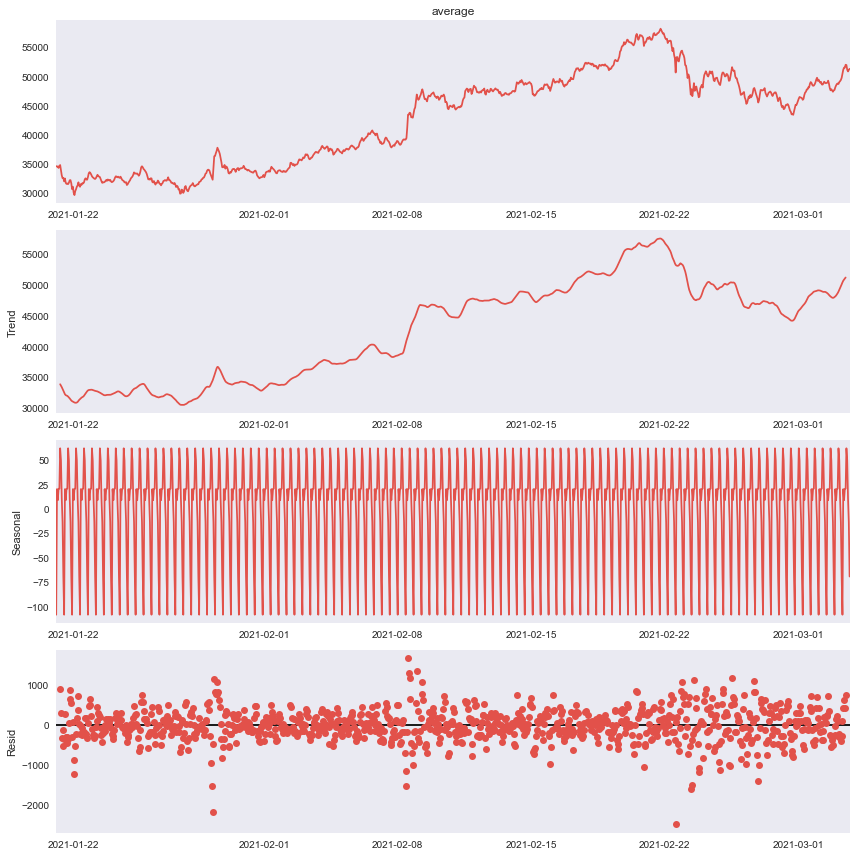

In [17]:
# seasonal decompose
res = sm.tsa.seasonal_decompose(data.average[-1000:], period=10)

with plt.rc_context():
    plt.rc("figure", figsize=(12,12))
    res.plot()

# Exogenous Variables: X

### Volume values

<AxesSubplot:xlabel='time'>

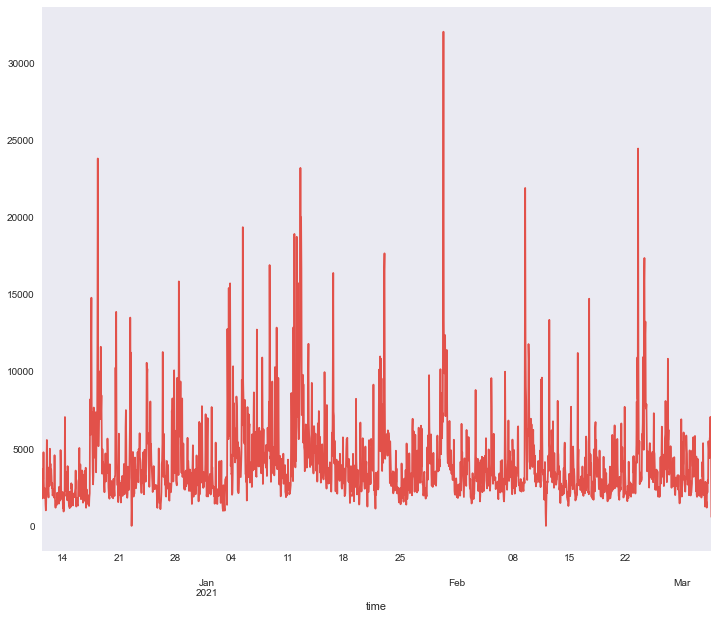

In [18]:
# volume is a very important feature
# it shows how much money is moving on a certain timeframe (in this case 1-hour)
x_volume = data.volume

# an offset of 1 day is added so we can use the previous day for predicting up to 24 hours
x_volume.index += pd.DateOffset(days=1)

# show the plot
x_volume.plot(figsize=(12,10))

### Open and Close values

In [19]:
# high and low values are already in the average, but open and close
# have valuable data so we include them as exogenous
# BUT VERY IMPORTANT: we will make them stationary to avoid contamination,
# because on the contrary of many examples found on the web, it's obvious that
# open and close have a trend very similar as the average which is our target
x_open = data.open
x_close = data.close

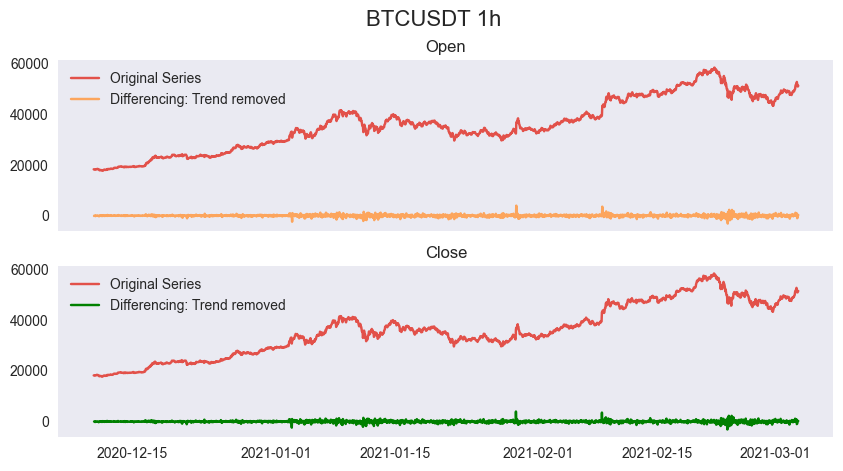

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(x_open, label='Original Series')
axes[0].plot(x_open.diff(1), label='Differencing: Trend removed')
axes[0].set_title('Open')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Differencing
axes[1].plot(x_close, label='Original Series')
axes[1].plot(x_close.diff(1), label='Differencing: Trend removed', color='green')
axes[1].set_title('Close')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('BTCUSDT 1h', fontsize=16)
plt.show()

In [21]:
# differencing
x_open = x_open.diff(1)
x_close = x_close.diff(1)

In [22]:
# introduce one day offset so we can predict up to 24 hours
x_open.index += pd.DateOffset(days=1)
x_close.index += pd.DateOffset(days=1)

### Twitter charts

<AxesSubplot:xlabel='date'>

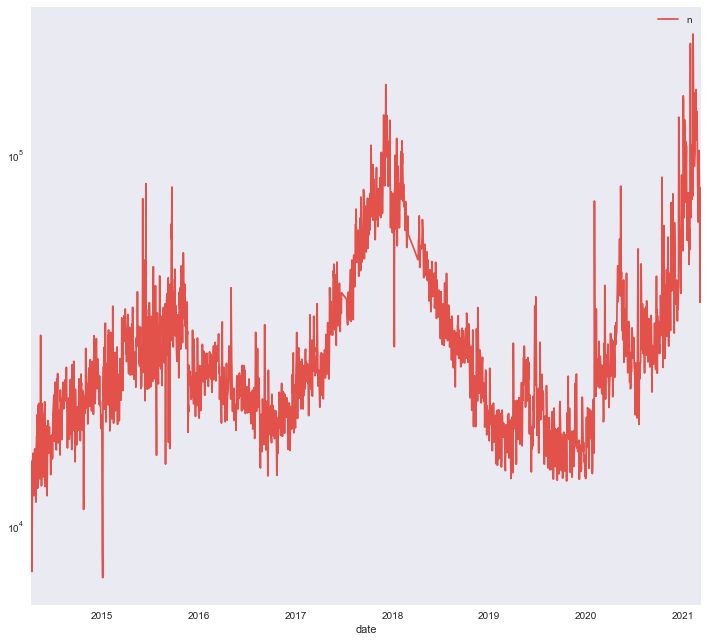

In [23]:
with open('data\\tweets_btc.csv') as f:
    reader = csv.reader(f)
    l = list(reader)
x_twitter = clean_bitinfo(l)

x_twitter.index = x_twitter.date
x_twitter = x_twitter.drop('date', axis=1)
x_twitter = x_twitter.asfreq('1h')
x_twitter['n'] = x_twitter['n'].interpolate(method='time')

x_twitter.plot(logy=True, figsize=(12,11))

### Marketcap

<AxesSubplot:xlabel='date'>

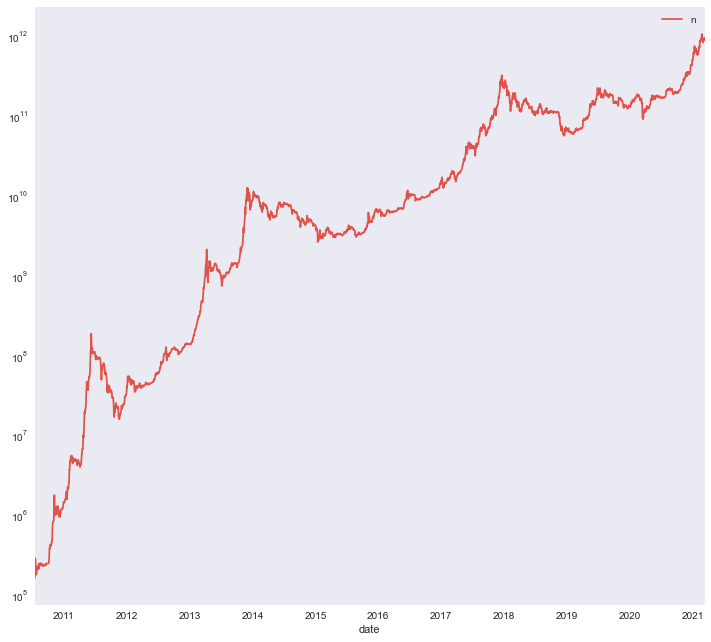

In [24]:
with open('data\\marketcap_btc.csv') as f:
    reader = csv.reader(f)
    l = list(reader)
x_marketcap = clean_bitinfo(l)

x_marketcap.index = x_marketcap.date
x_marketcap = x_marketcap.drop('date', axis=1)
x_marketcap = x_marketcap.asfreq('1h')
x_marketcap['n'] = x_marketcap['n'].interpolate(method='time')

x_marketcap.index += pd.DateOffset(days=1)
x_marketcap.plot(logy=True,figsize=(12,11))

### Load Google Trends

<AxesSubplot:xlabel='date'>

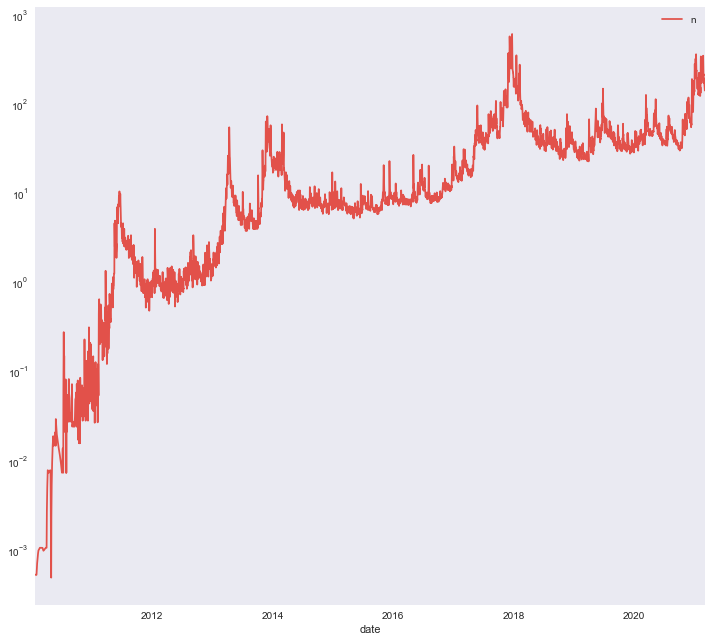

In [25]:
with open('data\\google_trends.csv') as f:
    reader = csv.reader(f)
    l = list(reader)
x_google = clean_bitinfo(l)

x_google.index = x_google.date
x_google = x_google.drop('date', axis=1)
x_google = x_google.asfreq('1h')
x_google['n'] = x_google['n'].interpolate(method='time')
x_google.index += pd.DateOffset(days=2)
x_google = x_google.dropna()
x_google.plot(logy=True, figsize=(12,11))

### Is data stationary?

In [26]:
# but: for AR model to work, the series should be stationary, which means that there is no long range trend
from statsmodels.tsa.stattools import adfuller
# H0: series is not stationary
# H1: series is stationary
adfuller(data.average)[1]

0.6708052412676121

In [27]:
# p is low, H0 must go? p > 0.05, we do not reject the null-hypothesis
# so the data is not stationary

<AxesSubplot:xlabel='time'>

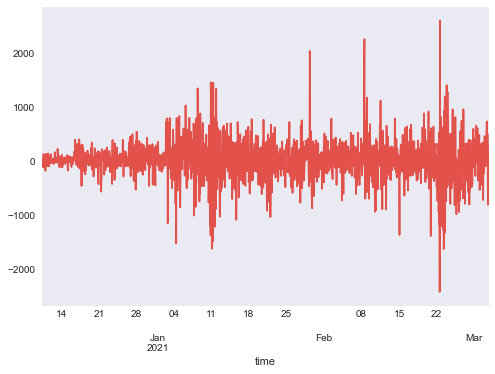

In [28]:
data.average.diff().plot()

In [29]:
# ARIMA takes care of this by itself

In [30]:
data = data.sort_index(ascending=True)

In [31]:
y = data.average.to_frame()

Autocorrelation plots

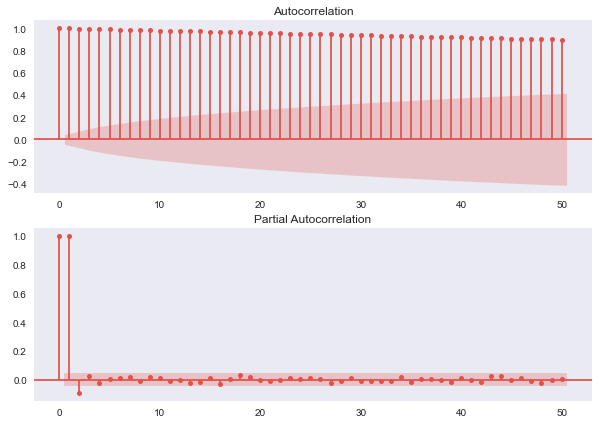

In [32]:
fig,ax = plt.subplots(2,1, figsize=(10,7))
fig = sm.tsa.graphics.plot_acf(y, lags=50, ax=ax[0])
fig = sm.tsa.graphics.plot_pacf(y, lags=50, ax=ax[1])
plt.show()

## Put all the X features together

In [33]:
# exogenous features
X = pd.DataFrame()

# volume
X['volume'] = x_volume

# open and close
X['open'] = x_open
X['close'] = x_close

# google trends
X['gtrends'] = x_google.n

# twitter
X['twitter'] = x_twitter.n

# marketcap
X['marketcap'] = x_marketcap.n

In [34]:
X = X.tail(X.shape[0]-25)
y = y.tail(y.shape[0]-25)

In [35]:
X.isna().sum()

volume       0
open         0
close        0
gtrends      0
twitter      0
marketcap    0
dtype: int64

In [36]:
# fix one nan in there
# X['open'] = X.open.interpolate(method='time')
# X['close'] = X.close.interpolate(method='time')

Make a subset of the whole data (just for speed purposes)

In [37]:
X_backup = X.copy()
y_backup = y.copy()

In [38]:
X = X.tail(2000)
y = y.tail(2000)

Log transform

In [39]:
def log_transform_clean(x):
    """
    This function applies a logarithmic transformation to a dataset
    """
    if np.isfinite(x) and x!=0:
        return np.log(x)
    else:
        return np.nan

In [40]:
def inv_log_transform_clean(x):
    """
    This function applies a logarithmic transformation to a dataset
    """
    if np.isfinite(x) and x!=0:
        return np.exp(x)
    else:
        return np.nan

In [41]:
for i in ['marketcap', 'twitter', 'gtrends', 'volume']:
    X[i] = X[i].apply(log_transform_clean)

In [42]:
X['volume'] = X.volume.fillna(X.volume.mean())

In [43]:
y['average'] = y['average'].apply(log_transform_clean)

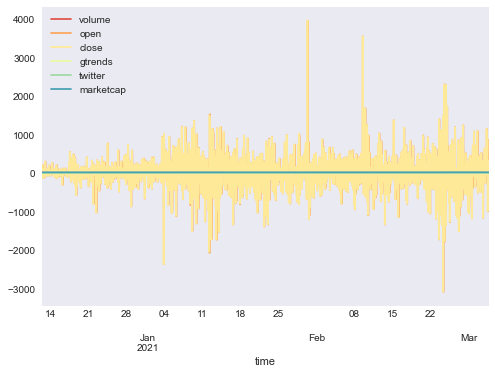

In [44]:
X.plot()
plt.show()

### Plot exogenous against endogenous variable

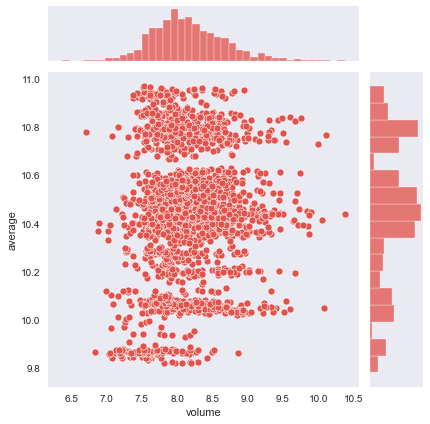

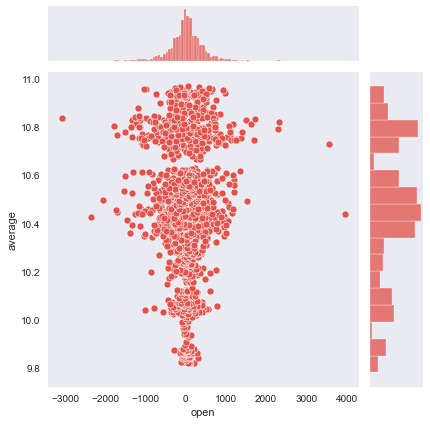

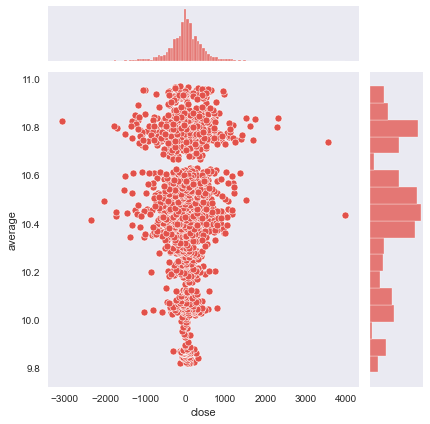

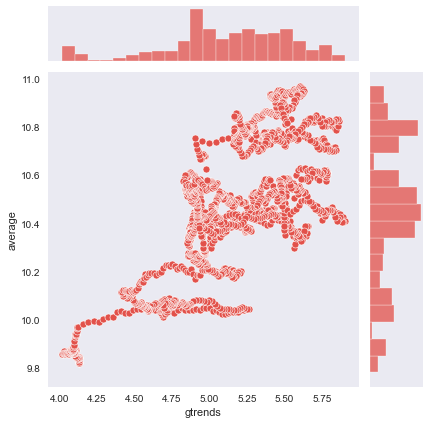

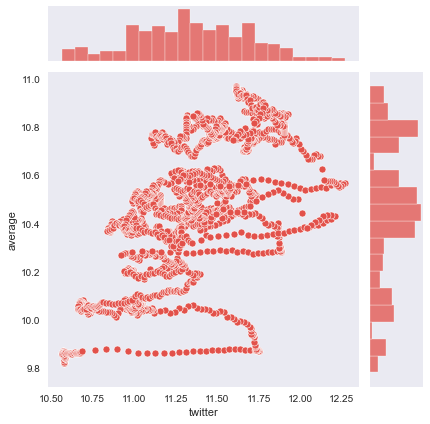

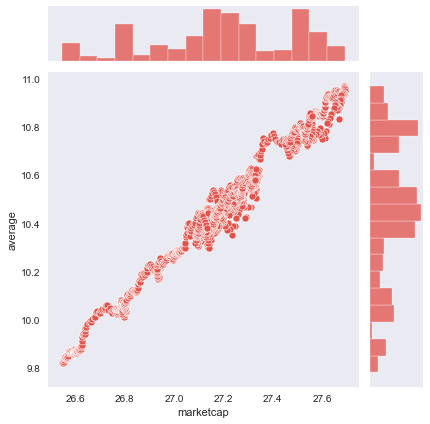

In [45]:
for i in X:

    sns.jointplot(
        x=X[i],
        y=y.average,
        kind='scatter' # or 'kde' or 'hex'
    )
    
plt.show()

All the X features against themselves, with a Kernel Density on top of them

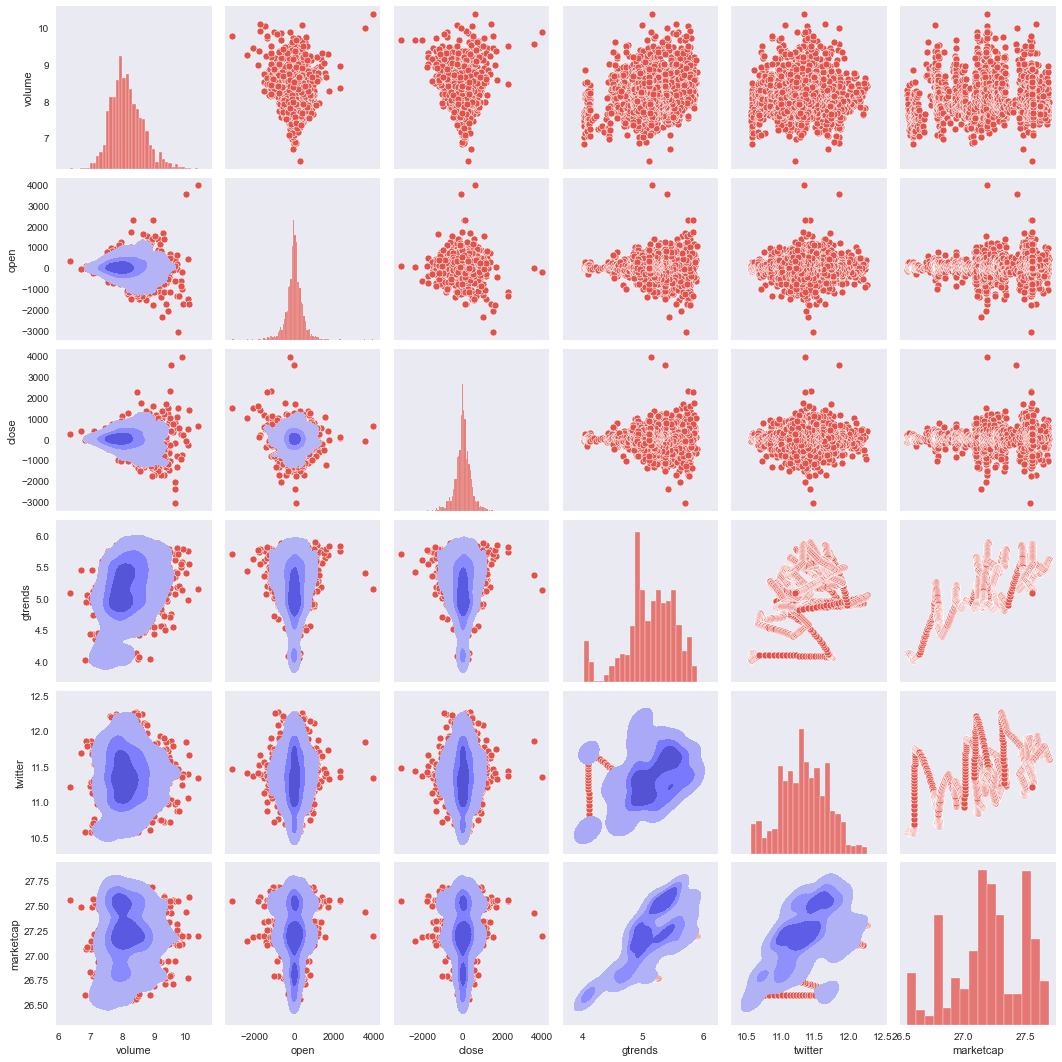

In [46]:
pp = sns.pairplot(
    data=X,
)

pp.map_lower(
    sns.kdeplot,
    levels=4,
    color='blue',
    fill=True,
    figsize=(40,40)
)

plt.show()

### Building SARIMAX model

In [47]:
def learn_and_predict(y, X):
    
    ### Scaling of y and X
    # scaling y
    scaler_y = MinMaxScaler()
    scaled_y = scaler_y.fit_transform(y)
    scaled_y = pd.DataFrame(scaled_y, columns=y.columns)

    # scaling X
    scaler_X = MinMaxScaler()
    scaled_X = scaler_X.fit_transform(X)
    scaled_X = pd.DataFrame(scaled_X, columns=X.columns)

    ### Train-Test Split
    # number of test samples
    n=12

    train_y, test_y = y[:-n], y[-n:]
    sc_train_y, sc_test_y = scaled_y[:-n], scaled_y[-n:]
    sc_train_y = pd.DataFrame(sc_train_y)
    sc_test_y = pd.DataFrame(sc_test_y)

    train_X, test_X = X[:-n], X[-n:]
    sc_train_X, sc_test_X = scaled_X[:-n], scaled_X[-n:]
    sc_train_X = pd.DataFrame(sc_train_X)
    sc_test_X = pd.DataFrame(sc_test_X)

    ### Build SARIMAX model
    model_sarimax = SARIMAX(
        endog=sc_train_y, 
        exog=sc_train_X,
#         order=(10,3,3),
        order=(1,3,1),
    )

    model_trained = model_sarimax.fit()

    predictions_scaled = model_trained.get_prediction(
        start=len(train_y),
        end=len(train_y)+len(test_y)-1,
        exog=sc_test_X,
    )
    
    predictions = scaler_y.inverse_transform([predictions_scaled.predicted_mean])
    predictions = pd.DataFrame(data=predictions.T)
    predictions = predictions.rename(columns={0:'predictions'})
    predictions['date'] = test_y.index
    predictions.index = pd.DatetimeIndex(predictions.date)
    predictions = predictions.drop('date', axis=1)
    predictions = predictions.asfreq('1h')

    predict_ci = predictions_scaled.conf_int()
    predict_ci = predict_ci.rename(columns={'lower average':'lower_average', 'upper average':'upper_average'})
    predict_ci['lower_average'] = scaler_y.inverse_transform([predict_ci['lower_average'].to_list()])[0]
    predict_ci['upper_average'] = scaler_y.inverse_transform([predict_ci['upper_average'].to_list()])[0]
    predict_ci['date'] = test_y.index
    predict_ci.index = pd.DatetimeIndex(predict_ci.date)
    predict_ci = predict_ci.drop('date', axis=1)
    predict_ci = predict_ci.asfreq('1h')

    predictions = pd.concat([predictions, predict_ci], axis=1)
    for i in predictions:
        predictions[i] = predictions[i].apply(inv_log_transform_clean)
    train_y['average'] = train_y['average'].apply(inv_log_transform_clean)
    test_y['average'] = test_y['average'].apply(inv_log_transform_clean)
    
    predictions
    return((model_trained, predictions, train_y, test_y))

In [48]:
model_trained, predictions, train_y, test_y = learn_and_predict(y,X)

In [49]:
model_trained.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                average   No. Observations:                 1963
Model:               SARIMAX(1, 3, 1)   Log Likelihood                6899.796
Date:                Sun, 04 Apr 2021   AIC                         -13781.592
Time:                        20:17:56   BIC                         -13731.366
Sample:                             0   HQIC                        -13763.132
                               - 1963                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
volume        -0.0079      0.001     -8.936      0.000      -0.010      -0.006
open           0.0565      0.001     52.282      0.000       0.054       0.059
close          0.0284      0.001     30.185      0.000       0.027       0.030
gtrends       -0.3755      0.113     -3.323      0.001      -0.597      -0.154
twitter       -0.0369      0.050     -0.731      0.465      -0.136       0.062
marketcap      0.9870      0.364      2.709      0.007       0.273       1.701
ar.L1         -0.4217      0.015    -28.747      0.000      -0.450      -0.393
ma.L1         -0.9961      0.016    -61.803      0.000      -1.028      -0.965
sigma2      5.118e-05   1.28e-06     39.853      0.000    4.87e-05    5.37e-05
===================================================================================
Ljung-Box (L1) (Q):                   6.33   Jarque-Bera (JB):              1264.58
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.40
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Show Model Diagnostics

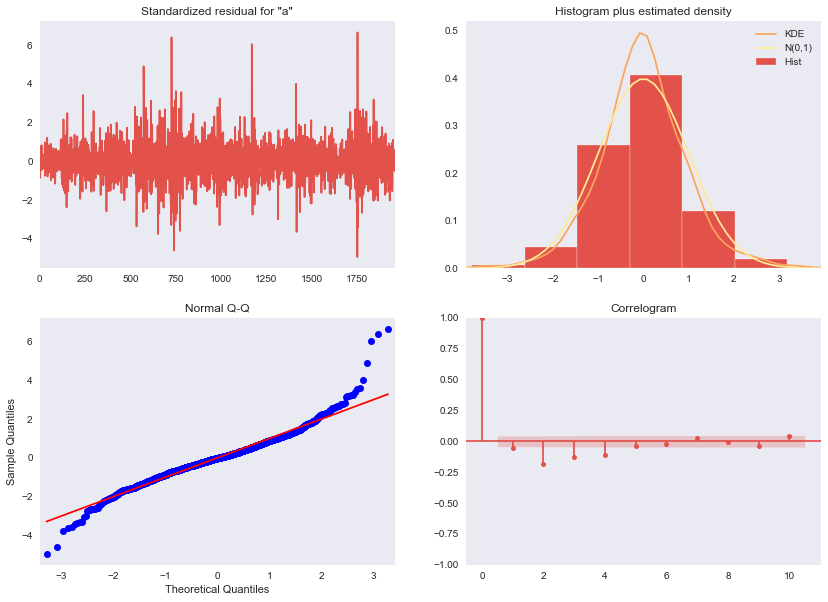

In [50]:
model_trained.plot_diagnostics(figsize=(14,10))
plt.show()

In [51]:
comparison = pd.concat([test_y, predictions], axis=1)
comparison

average   predictions  lower_average  upper_average
2021-03-03 06:00:00  49357.990  49161.508999   48347.787903   49988.925490
2021-03-03 07:00:00  49717.055  49459.809405   47938.602887   51029.287444
2021-03-03 08:00:00  50375.485  49622.419870   47199.008715   52170.259944
2021-03-03 09:00:00  51107.500  50053.716375   46612.879031   53748.547076
2021-03-03 10:00:00  51471.560  49764.554721   45258.449567   54719.305019
2021-03-03 11:00:00  51466.165  49693.797448   44041.144109   56071.965312
2021-03-03 12:00:00  51965.085  50075.691967   43158.242937   58101.877077
2021-03-03 13:00:00  51914.155  50061.598703   41878.477430   59843.714922
2021-03-03 14:00:00  51107.575  49326.576690   39978.308826   60860.782745
2021-03-03 15:00:00  50818.000  49789.434489   39028.697256   63517.051836
2021-03-03 16:00:00  51097.460  50357.585663   38114.613809   66533.179282
2021-03-03 17:00:00  51263.415  50889.288393   37130.951909   69745.577207

Predictions

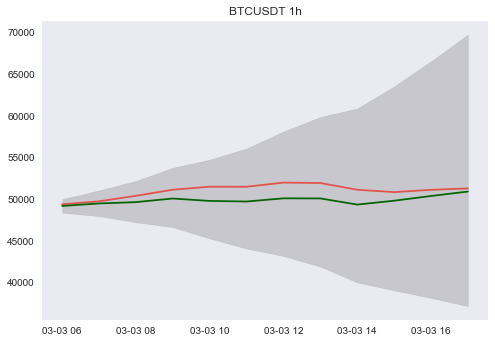

In [52]:
# plot
plt.plot(comparison.average)
plt.plot(comparison.predictions, color='darkgreen')
plt.fill_between(comparison.lower_average.index, 
                 comparison.lower_average, 
                 comparison.upper_average, 
                 color='k', alpha=.15)

plt.title("BTCUSDT 1h")
plt.show()

Predictions adding the previous values

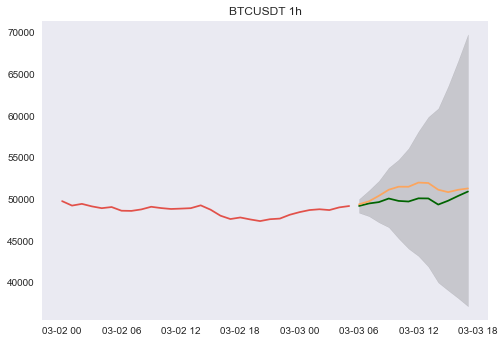

In [53]:
# plot
plt.plot(train_y[-30:])
plt.plot(predictions.predictions, color='darkgreen')
plt.plot(comparison.average)

plt.fill_between(predictions.lower_average.index, 
                 predictions.lower_average, 
                 predictions.upper_average, 
                 color='k', alpha=.15)

plt.title("BTCUSDT 1h")
plt.show()

### Show Chart and Predictions

In [54]:
# shows the candlestick chart with the predictions on top
add_predictions()
chart

FigureWidget({
    'data': [{'close': array([51734.88, 51727.08, 52236.31, ..., 50767.36, 51077.  , 51336.81])…

In [55]:
# remove the predictions if necessary
remove_from_plot()

Some accuracy metrics

In [56]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE : Mean absolute percentage error
    me = np.mean(forecast - actual)             # ME : Mean error
    mae = np.mean(np.abs(forecast - actual))    # MAE : Mean absolute error
    mpe = np.mean((forecast - actual)/actual)   # MPE : Mean percentage error
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE : Root mean square error
    corr = np.corrcoef(forecast, actual)[0,1]   # corr : Pearson product-moment correlation coefficients.
    mins = np.amin(np.hstack([np.array(forecast), 
                              np.array(actual)]), axis=0)
    maxs = np.amax(np.hstack([np.array(forecast), 
                              np.array(actual)]), axis=0)
    minmax = 1 - np.mean(mins/maxs)             # minmax
#     acf1_ = acf(fc-actual, nlags=1, fft=True)[1]# ACF1 : Autocorrelation of errors at lag 1.
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
#             'acf1':acf1_, 
            'corr':corr, 'minmax':minmax})

In [57]:
forecast_accuracy(predictions.predictions, test_y.average)

{'mape': 0.021769532861050166,
 'me': -1117.121856416917,
 'mae': 1117.121856416917,
 'mpe': -0.021769532861050166,
 'rmse': 1283.1133514336134,
 'corr': 0.5689385055233881,
 'minmax': 0.053951148179871566}

# Realtime 1min candles prediction

### Functions

In [58]:
def web_socket():
    """
    Signature: web_socket() -> 'BinanceSocketManager'
    
    Docstring:
    Deals with real-time data.
    Also takes care of plotting.
    It makes use of Binance' API ('https://api.binance.com/api/v3/')
    
    Returns
    -------
    BinanceSocketManager

    Example
    -------
    
    >>> web_socket()
    """

    # real-time data and chart
    # have to be global for real-time interaction
    global rtdata
    global rtchart

    # initialize client without API keys, as they are not needed for now
    client = Client("", "")

    # this function runs every time the socket receives new data
    def process_message(x):
        global rtdata
        global rtchart

        # get the last minute from the existing data
        t1 = pd.to_datetime(rtdata.tail(1).index.values[0])
        
        # get the last minute from the new data
        t2 = pd.to_datetime(x['k']['t'], unit='ms')
        
        # convert the new data (kline tipe) into a dataframe
        new_df = pd.DataFrame([x['k']])
        
        # change the data type for t
        new_df['t'] = pd.to_datetime(new_df['t'], unit='ms')
        
        # change the data type for T
        new_df['T'] = pd.to_datetime(new_df['T'], unit='ms')
        
        # change to index into datetime with frequency = minutes
        new_df.index = pd.DatetimeIndex(new_df.t, freq='min')
        
        # drop the t column as it is now the index
        new_df = new_df.drop('t', axis=1)
        
        # reindex the dataframe using the existing data as a reference
        new_df.reindex(columns=rtdata.columns)

        # if the timestamps are different then append new values
        if t1 != t2:
            rtdata = pd.concat([rtdata, new_df], axis=0)
        
        #if it's still the same minute then update the value
        #this way we can see every change even before the candle is over
        else:
            rtdata.loc[rtdata.index[-1]] = new_df.loc[new_df.index[-1]]
        
        # update the chart
        rtchart.data[0].x=rtdata.index
        rtchart.data[0].open=rtdata.o
        rtchart.data[0].high=rtdata.h
        rtchart.data[0].low=rtdata.l
        rtchart.data[0].close=rtdata.c
        
        # recenter the plot leaving some space for predictions
        rtchart.update_xaxes(range=[rtdata.index[-16],rtdata.index[-1] + pd.Timedelta(minutes=5)])
        pass

    # get the last 1 hour of 1-minute candles data
    klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1MINUTE, "1 hour ago UTC")
    
    # convert to a dataframe using the appropriate format provided by the API documentation
    rtdata = pd.DataFrame(columns=['t','o','h','l','c','v','T','q','n','V','Q','B'])
    
    # concatenate every candle
    rtdata = pd.concat([rtdata, pd.DataFrame([i for i in klines], columns=rtdata.columns)], axis=0)
    
    # change the data type for t
    rtdata['t'] = pd.to_datetime(rtdata['t'], unit='ms')
    
    # change the data type for T
    rtdata['T'] = pd.to_datetime(rtdata['T'], unit='ms')
    
    # change to index into datetime with frequency = minutes
    rtdata.index = pd.DatetimeIndex(rtdata.t, freq='min')
    
    # drop the t column as it is now the index
    rtdata = rtdata.drop('t', axis=1)

    # initialize a socket manager
    bm = BinanceSocketManager(client)
    
    # start the kline socket to get bitcoin data in realtime
    bm.start_kline_socket("BTCUSDT", process_message)
    
    # adjust the plot's y-range
    rtchart.update_yaxes(range=[rtdata['l'].tail(15).min(),rtdata['h'].tail(15).max()])
    
    # return the socket manager
    return(bm)

In [59]:
# real time predictions 1min candles
def learn_and_predict_realtime(h,l):
    m = (h+l)/2
    m_df = pd.DataFrame(m)
    times = rtchart.data[0]['x'][-m_df.shape[0]:]
    m_df['times'] = times
    m_df.index = pd.DatetimeIndex(m_df.times)
    m_df = m_df.drop('times', axis=1)
    m_df = m_df.asfreq('1min')

    # model for real time
    rt_model = pm.ARIMA(
        order=(5,1,0)
    )

    rt_model_trained = rt_model.fit(m)

    # Forecast
    n_periods = 5

    fc, confint = rt_model_trained.predict(
        n_periods=n_periods,
        return_conf_int=True
    )

    index_of_fc = pd.date_range(m_df.index[-1], periods = n_periods, freq='min')

    return((rt_model_trained, fc, confint, index_of_fc, m_df, n_periods))


In [60]:
def plot_realtime_results(fc, confint, index_of_fc):
    # make series for plotting purpose
    fc_series = pd.Series(fc, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.plot(m_df[0])
    plt.plot(fc_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=.15)

    plt.title("BTCUSDT 1m")
    plt.show()
    pass

In [61]:
def add_traces_to_realtime(m_df, n_periods, fc):
    # add traces to realtime chart
    lastminute = m_df.index[-1]

    index = pd.date_range(
        start=lastminute,
        periods=n_periods,
        freq='1min'
    )

    rt_predictions = pd.DataFrame(
        fc,
        index=index
    )

    rtchart.add_trace(
        go.Scatter(
            name='prediction',
            x=rt_predictions.index,
            y=rt_predictions[0],
            mode="markers",
            line=dict(color='white')
        )
    )

    rtchart.add_trace(
        go.Scatter(
            name='lb_conf',
            x=index,
            y=confint.T[0],
            fill=None,
            mode='lines',
            line_color='indigo',
        )
    )
    rtchart.add_trace(
        go.Scatter(
            name='ub_conf',
            x=index,
            y=confint.T[1],
            fill='tonexty',
            # fill area between trace0 and trace1
            mode='lines',
            line_color='indigo'
        )
    )
    pass

In [62]:
def remove_from_realtime():
    # removes extra traces to realtime plot
    rtchart.data = [rtchart.data[0]]
    pass

### Execution

In [72]:
# initialize the socket that will retrieve real-time data
# the same function will update the plot
# no workaround to modularize further founded so far
bm = web_socket()

# start the socket
bm.start()

In [73]:
rtchart.show()

In [65]:
# in case we run the whole notebook at once, the socket needs some seconds to start
time.sleep(5)

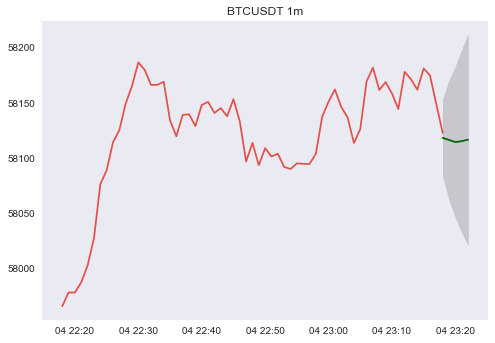

In [66]:
h = rtchart.data[0]['high'].astype(np.float)
l = rtchart.data[0]['low'].astype(np.float)
rt_model_trained, fc, confint, index_of_fc, m_df, n_periods = learn_and_predict_realtime(h,l)
plot_realtime_results(fc, confint, index_of_fc)

In [67]:
display(rtchart)

FigureWidget({
    'data': [{'close': array(['57990.00000000', '57974.95000000', '57974.47000000', '57993.2600…

In [68]:
add_traces_to_realtime(m_df, n_periods, fc)
pass

In [69]:
# in case we need to remove real-time predictions
remove_from_realtime()

In [74]:
# close the socket
bm.close()

In [71]:
# display charts
display(chart, rtchart)

FigureWidget({
    'data': [{'close': array([51734.88, 51727.08, 52236.31, ..., 50767.36, 51077.  , 51336.81])…

FigureWidget({
    'data': [{'close': array(['57990.00000000', '57974.95000000', '57974.47000000', '57993.2600…